### Predicting the Present with Google Trends

In this notebook, I try to replicate two figures extracted from the paper "Predicting the Present with Google Trends",HYUNYOUNG CHOI and HAL VARIAN, Google, Inc., California, USA.

### Imports

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

DATA_FOLDER = 'data/'

# Figure 2 replication

## 1 - Data wrangling

### Loading the "Motor Vehicles and Parts Dealers" dataset

In [3]:
autos = pd.read_csv(DATA_FOLDER+"merged_autos.csv")
autos.Period = pd.to_datetime(autos.Period)

### Adding the log of the sales

In [4]:
autos["logsales"] = np.log(autos["sales"])
autos

,Period,sales,suvs,insurance,logsales
0,2004-01-01,61287,0.00,0.00,11.023323
1,2004-02-01,65381,-0.12,-0.01,11.087987
2,2004-03-01,78843,-0.05,-0.09,11.275214
3,2004-04-01,73422,-0.12,-0.08,11.203979
4,2004-05-01,77662,-0.07,-0.07,11.260121
...,...,...,...,...,...
86,2011-03-01,75982,-0.03,-0.19,11.238252
87,2011-04-01,70364,-0.08,-0.20,11.161437
88,2011-05-01,70070,-0.16,-0.22,11.157250
89,2011-06-01,70747,-0.12,-0.16,11.166865


## 2 - In-sample check

We first compare our in-sample regression results with the paper tables.

### Logistic regression for baseline AR-1 model

In [5]:
res_base = AutoReg(autos['logsales'], [1, 12]).fit()
print(res_base.summary())

                            AutoReg Model Results                             
Dep. Variable:               logsales   No. Observations:                   91
Model:             Restr. AutoReg(12)   Log Likelihood                  89.115
Method:               Conditional MLE   S.D. of innovations              0.078
Date:                Fri, 18 Dec 2020   AIC                             -4.993
Time:                        14:57:06   BIC                             -4.873
Sample:                            12   HQIC                            -4.945
                                   91                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.6727      0.749      0.898      0.369      -0.795       2.141
logsales.L1      0.6435      0.072      8.948      0.000       0.503       0.784
logsales.L12     0.2957      0.071      4.13

### Adding Trends

In [6]:
res_trends = AutoReg(autos['logsales'], [1, 12], exog=pd.concat([autos['suvs'], autos['insurance']], axis=1)).fit()
print(res_trends.summary())

                             AutoReg Model Results                              
Dep. Variable:                 logsales   No. Observations:                   91
Model:             Restr. AutoReg-X(12)   Log Likelihood                 106.312
Method:                 Conditional MLE   S.D. of innovations              0.063
Date:                  Fri, 18 Dec 2020   AIC                             -5.377
Time:                          14:57:06   BIC                             -5.197
Sample:                              12   HQIC                            -5.305
                                     91                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.4580      0.759     -0.603      0.546      -1.946       1.030
logsales.L1      0.6195      0.061     10.131      0.000       0.500       0.739
logsales.L12     0.4287     

Amazing we got exactly the same results!

## 3 - Out-of-sample forecasting

Now that we are sure that we use the right regression model, we can start the forecast.

My understanding of the paper is that they use a rolling window of size k until t-1  to estimate the model and then predict yt using yt-1 and yt-12.

The paper uses k=17. However, I will use k=24 as in my implementation, predict() only works for k>=2*12. Futhermore, adding 7 periods to the window shouldn't change much the results.

In [7]:
k = 24

### Baseline model

In [8]:
endog = autos['logsales']

basedf = pd.DataFrame()
for i in range(len(autos)-k):
    r = i+k # end of the window
    estimates = AutoReg(endog[i:r], [1, 12]).fit() # estimate the model using the data for periods k through t-1
    pred = estimates.predict(start=k, end=k) # forecast yt using yt-1 and yt-12
    basedf = basedf.append(pd.DataFrame(pred, columns=['logsales'])) # add the prediction yt to the datframe

# add the corresponding dates to the dataframe to be able later to select the recession period and to plot it
basedf['Period'] = autos['Period'] 

### Trends model

Now, we add the contemporaneous data of Google Trends as predictors:

In [9]:
exog = pd.concat([autos['suvs'], autos['insurance']], axis=1)

#same as for the baseline model (but with exog data)
trendsdf = pd.DataFrame()
for i in range(len(autos)-k):
    r = i+k
    estimates = AutoReg(endog[i:r], [1, 12], exog=exog[i:r]).fit()
    pred = estimates.predict(start=k, end=k, exog_oos=exog[r:r+1])
    trendsdf = trendsdf.append(pd.DataFrame(pred, columns=['logsales']))

trendsdf['Period'] = autos['Period']

## 4 - MAE (mean absolute error)

We cut the autos dataframe to be able to compare it with our predictions which start on January 2006:

In [10]:
autos_reduced = autos[k:]

The paper values are written in comment for comparison

In [11]:
baseMAE = meanabs(basedf['logsales'], autos_reduced['logsales']) #6.34
baseMAE

0.0647494306398062

In [12]:
trendsMAE = meanabs(trendsdf['logsales'], autos_reduced['logsales']) #5.66
trendsMAE

0.05341705402238256

### Overall improvement

In [13]:
overall_improvement = (baseMAE-trendsMAE)/baseMAE*100 #10.5
overall_improvement

17.50189384747548

Please note that I'm not using exaclty the same method than the one of the paper to compute the improvement. Indeed, we would get 12% instead of 10.5% with my method on the paper MAE values.

### Focusing on the recession (December 2007 through June 2009):

We only keep the recession period in the dataframes:

In [14]:
autos_recession = autos[(autos.Period >= datetime(2007,1,1)) & (autos.Period <= datetime(2009,1,1))]
base_recession = basedf[(basedf.Period >= datetime(2007,1,1)) & (basedf.Period <= datetime(2009,1,1))]
trends_recession = trendsdf[(trendsdf.Period >= datetime(2007,1,1)) & (trendsdf.Period <= datetime(2009,1,1))]

Now we can compute the MAE over this period:

In [15]:
baseMAE_recession = meanabs(base_recession['logsales'], autos_recession['logsales']) #6.96
baseMAE_recession

0.05902809272803026

In [16]:
trendsMAE_recession = meanabs(trends_recession['logsales'], autos_recession['logsales']) #8.86
trendsMAE_recession

0.04464111290070079

In [17]:
recession_improvement = (baseMAE_recession-trendsMAE_recession)/baseMAE_recession*100 #21.5
recession_improvement

24.37310636753409

## 5 - Replicated figure

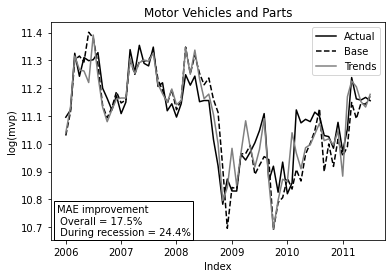

In [18]:
plt.plot(autos_reduced['Period'], autos_reduced['logsales'], label='Actual', color='black')
plt.plot(basedf['Period'], basedf['logsales'], label='Base', linestyle='dashed', color='black')
plt.plot(trendsdf['Period'], trendsdf['logsales'], label='Trends', color='grey')

plt.title('Motor Vehicles and Parts')
plt.xlabel('Index')
plt.ylabel('log(mvp)')
plt.legend(loc='upper right')

# add text
text = 'MAE improvement \n Overall = {:.1f}% \n During recession = {:.1f}%'.format(overall_improvement, recession_improvement)
props = dict(boxstyle='square', facecolor='none', edgecolor='black')

plt.text(datetime(2005,11,1), 10.67, text, bbox=props)
plt.show()

## 6 - Conclusions

During this replication, I tried to stay as close as possible to the paper.

First, I got exactly the same AR-1 models on the whole dataset.
Then, for the out-of-sample forecasting, I got slighlty better predictions as I took a slightly bigger k for the rolling window. Overall the trends (no pun intented ;)) in the graph look the same and we also find a bigger improvement with the trends model during the recession period.

PS: it's worth noting that the authors of the paper used R to build their models and that the used library might higly differ from the statsmodel one provided in python.

# Table 1 replication

## 1 - Data wrangling

### Loading the US Department of Labor data & the query volume of related search terms from Google Trends

In [75]:
claims = pd.read_csv(DATA_FOLDER+"merged_iclaims.csv")
claims.Index = pd.to_datetime(claims.Index)
print(claims)

         Index  claims.sa  claims.nsa       Jobs  Welfare...Unemployment
0   2004-01-10     354000      677897   6.066862               -7.574152
1   2004-01-17     362000      490763  -3.558773              -25.237886
2   2004-01-24     353000      382262  -6.184409              -17.401619
3   2004-01-31     376000      406298  -7.935044              -18.815352
4   2004-02-07     380000      433234 -13.310680              -24.104085
..         ...        ...         ...        ...                     ...
386 2011-06-04     430000      366816  -8.625037               20.205657
387 2011-06-11     420000      400608  -1.740796               22.864625
388 2011-06-18     429000      394286  -1.981555               21.773594
389 2011-06-25     432000      406633  -0.978706               13.977618
390 2011-07-02     427000      425640  -0.350857               17.056643

[391 rows x 5 columns]


As mentionned in the paper, we will work with the seasonally adjusted data and consider the log of the claims:

In [83]:
claims["log"] = np.log(claims["claims.sa"])

In [105]:
claims

,Index,claims.sa,claims.nsa,Jobs,Welfare...Unemployment,log
0,2004-01-10,354000,677897,6.066862,-7.574152,12.777052
1,2004-01-17,362000,490763,-3.558773,-25.237886,12.799399
2,2004-01-24,353000,382262,-6.184409,-17.401619,12.774223
3,2004-01-31,376000,406298,-7.935044,-18.815352,12.837344
4,2004-02-07,380000,433234,-13.310680,-24.104085,12.847927
...,...,...,...,...,...,...
386,2011-06-04,430000,366816,-8.625037,20.205657,12.971540
387,2011-06-11,420000,400608,-1.740796,22.864625,12.948010
388,2011-06-18,429000,394286,-1.981555,21.773594,12.969212
389,2011-06-25,432000,406633,-0.978706,13.977618,12.976181


### Removing the seasonal component (Trends)

The author specifies using stl in R to remove the seasonal component of the Trends data. This means that he uses the Loess method. However, it's still needed to define the period of the seasonality that should be removed. As the data is provided for each week, the seasonality could be either weekly, quaterly or annually. To do so, we plot the a subset of the Trend data:

In [106]:
df_reduced = claims[:30]

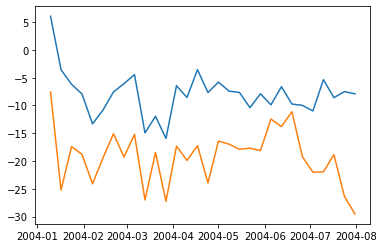

In [107]:
plt.plot(df_reduced['Index'], df_reduced['Jobs'], label='Jobs')
plt.plot(df_reduced['Index'], df_reduced['Welfare...Unemployment'], label='Welfare...Unemployment')
plt.show()

Unfortunately, we cannot clearly see a monthly, quarterly or annual seasonality. Thus, one should use another method.

Removing the same seasonality as the one that as been removed by the US Department of Labor might be a good idea. After some research, we can find that they use the X-13ARIMA-SEATS for monthly data. However, to use statsmodels.tsa.x13.x13_arima_analysis, one should download the software. Thus, we will simply remove a monthly seasonal component (period=4);

In [108]:
res_jobs = STL(claims['Jobs'], period=4).fit()
res_unemployement = STL(claims['Welfare...Unemployment'], period=4).fit()

Now that the seasonal component has been extracted, we can remove it from the data. However, we are not sure wether the model is additive(Y[t] = T[t] + S[t] + e[t]) or multiplicative (Y[t] = T[t] * S[t] * e[t]). As I doubt that the residual would bring anything meaningful to the model's performance, I decide to solve the question by only keeping the Trend component:

In [155]:
exog = pd.concat([res_jobs.trend, res_unemployement.trend], axis=1)

## 2 - Model fitting

The baseline regression being a simple AR-1 model on the log of initial claims, we first check that we get the same parameters for the model.
We compare two ways of computing the AR-1: AutoReg and SARIMAX.

In [171]:
endog = claims['log']

### Baseline

In [137]:
res_base = AutoReg(endog, 1).fit()
print(res_base.summary())

                            AutoReg Model Results                             
Dep. Variable:                    log   No. Observations:                  391
Model:                     AutoReg(1)   Log Likelihood                 669.170
Method:               Conditional MLE   S.D. of innovations              0.044
Date:                Fri, 18 Dec 2020   AIC                             -6.254
Time:                        16:57:31   BIC                             -6.224
Sample:                             1   HQIC                            -6.242
                                  391                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2549      0.129      1.973      0.048       0.002       0.508
log.L1         0.9802      0.010     97.618      0.000       0.961       1.000
                                    Roots           

In [156]:
res_base2 = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c').fit()
print(res_base2.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  391
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 669.667
Date:                Fri, 18 Dec 2020   AIC                          -1333.333
Time:                        17:37:59   BIC                          -1321.427
Sample:                             0   HQIC                         -1328.614
                                - 391                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2544      0.144      1.763      0.078      -0.028       0.537
ar.L1          0.9802      0.011     87.300      0.000       0.958       1.002
sigma2         0.0019   8.65e-05     21.838      0.0

### Now adding Trends

In [138]:
res_trends = AutoReg(endog, 1, exog=exog).fit()
print(res_trends.summary())

                            AutoReg Model Results                             
Dep. Variable:                    log   No. Observations:                  391
Model:                   AutoReg-X(1)   Log Likelihood                 674.676
Method:               Conditional MLE   S.D. of innovations              0.043
Date:                Fri, 18 Dec 2020   AIC                             -6.272
Time:                        16:57:37   BIC                             -6.221
Sample:                             1   HQIC                            -6.252
                                  391                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1067      0.288      3.849      0.000       0.543       1.670
log.L1         0.9142      0.022     40.909      0.000       0.870       0.958
trend          0.0004      0.000      0.742      0.4

In [157]:
res_trends2 = sm.tsa.SARIMAX(endog, exog=exog, order=(1, 0, 0), trend='c').fit()
print(res_trends2.summary())

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  391
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 669.036
Date:                Fri, 18 Dec 2020   AIC                          -1328.073
Time:                        17:38:12   BIC                          -1308.229
Sample:                             0   HQIC                         -1320.207
                                - 391                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6872      0.227      3.023      0.002       0.242       1.133
trend          0.0013      0.001      1.022      0.307      -0.001       0.004
trend          0.0022      0.001      2.318      0.0

Please note that the first trend parameter refers to "Jobs" while the second refers to "Welfare...Unemployment".

Using Autoreg, we obtain results that are much closer to the paper for the Trends model.

The parameters are exactly the same for the baseline! Regarding the model using Trends data, the parameters differ slighlty as we couldn't proceed exactly in the same way as the paper to remove the seasonality from Trends. But this is close enough!

## 3 - Forecasting

We can now start the one-step-ahead out-of-sample forecast!

The minimum period k for the rolling window is 4 for the baseline model and 6 for the trends model. Trying to use a smaller window (such as one to reproduce a one-step-ahead forecast as described in the paper) leads to an error message.

To be able to compare both models, one should use the same window size. Consequently k is set at 6.

In [231]:
k=6

In [232]:
basedf = pd.DataFrame()
for i in range(len(claims)-k):
    r = i+k # end of the window
    estimates = AutoReg(endog[i:r], 1).fit() # estimate the model using the data for periods k through t-1
    pred = estimates.predict(start=k, end=k) # forecast yt using yt-1 and yt-12
    basedf = basedf.append(pd.DataFrame(pred, columns=['log'])) # add the prediction yt to the datframe

# add the corresponding dates to the dataframe to be able later to select the recession period and to plot it
basedf['Index'] = claims['Index'] 

In [234]:
#same as for the baseline model (but with exog data)
trendsdf = pd.DataFrame()
for i in range(len(claims)-k):
    r = i+k
    estimates = AutoReg(endog[i:r], 1, exog=exog[i:r]).fit()
    pred = estimates.predict(start=k, end=k, exog_oos=exog[r:r+1])
    trendsdf = trendsdf.append(pd.DataFrame(pred, columns=['log']))

trendsdf['Index'] = claims['Index']

## 4 - MAE & replicated figure

Let's compute the Mean Average Error (MAE) of both models around the turning points.

The first k rows (=week) being used to forecast the first sample, one should exclude them when computing the MAE:

In [235]:
claims_reduced = claims[k:]

Overall MAE results:

In [250]:
baseMAE = meanabs(basedf['log'], claims_reduced['log'])
trendsMAE = meanabs(trendsdf['log'], claims_reduced['log'])
improvement = (baseMAE-trendsMAE)/baseMAE*100
    
print("baseline = {:.1f}% \nwith Trends data = {:.1f}% \nMAE improvement = {:.1f}% \n"\
      .format(baseMAE, trendsMAE, improvement))

baseline = 0.0% 
with Trends data = 0.1% 
MAE improvement = -130.5% 



These results doesn't make sense...


Nevertheless, below is the code necessary to compute the MAE for the different turning points:

In [238]:
#Compute the MAEs for two models as well as the improvement from the first (base) to the second (trends) model for a given period
def get_MAE(original, base, trends, period):
    original_cut = original[(original.Index >= period[0]) & (original.Index <= period[1])]
    base_cut = base[(base.Index >= period[0]) & (base.Index <= period[1])]
    trends_cut = trends[(original.Index >= period[0]) & (trends.Index <= period[1])]
    
    baseMAE = meanabs(base_cut['log'], original_cut['log'])
    trendsMAE = meanabs(trends_cut['log'], original_cut['log'])
    improvement = (baseMAE-trendsMAE)/baseMAE*100
    
    print("baseline = {:.1f}% \nwith Trends data = {:.1f}% \nMAE improvement = {:.1f}% \n"\
      .format(baseMAE, trendsMAE, improvement))
    
    df = pd.DataFrame([period[0].strftime("%Y-%m-%d"), period[1].strftime("%Y-%m-%d"), baseMAE, trendsMAE, improvement],\
                    columns=['Start', 'End', 'MAE base', 'MAE trends', 'l-ratio'])
    print(df)
    return df

In [246]:
#List of the Turning points
periods = [[datetime(2009,3,1), datetime(2009,5,1)], [datetime(2009,12,1), datetime(2010,2,1)],\
          [datetime(2010,7,15), datetime(2010,7,15)], [datetime(2011,1,1), datetime(2011,5,1)]]

#initialization of the table
table = pd.DataFrame()

Finally, the following cell displays the Table 1:

In [248]:
for period in periods:
    table.append(get_MAE(claims_reduced, basedf, trendsdf, period), ignore_index=True)

print("Behavior of MAE around Turning Points")

baseline = 0.0% 
with Trends data = 0.1% 
MAE improvement = -241.9% 



ValueError: Shape of passed values is (5, 1), indices imply (5, 5)

## 5 - Conclusions

For this second replication, I first did some data wrangling in order to get a dataset as close as possible from the paper. To do so, I had to remove the seasonality from the provided Trends dataset using the available python library. This might have worked pretty well as I was able to get similar parameters for both, the baseline and the trends AR-1 model, after comparing different way of computing the regression.

Then, for the out-of-sample forecasting, I used a rolling window of period k=6 as the one-step-ahead forecast doesn't seem to work with AutoReg.
Finally, I wrote the code allowing to compute the MAE around Turning points and fill the table period (=turning point) by period. However, the results doesn't make sense so I didn't display them.

Indeed the improvement is hugely negative as the MAE is 0% for the baseline and 0.1% for trends. The small MAEs are perhaps due to the fact that I use a rolling window instead of the one-step-ahead forecast.

PS: it's worth noting that the authors of the paper used R to build their models and thus the library they used might higly differ from the statsmodel one provided in python.